## MLP를 이용한 Classification
###### 가상의 데이터 샘플을 분류하는 MLP 모델 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

#### Pseudo Data Generation

In [2]:
n_dim = 2

x_train, y_train = make_blobs(
    n_samples=200,
    n_features=n_dim,
    centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    shuffle=True,
    cluster_std=0.3
)
x_valid, y_valid = make_blobs(
    n_samples=50,
    n_features=n_dim,
    centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    shuffle=True,
    cluster_std=0.3
)
x_test, y_test = make_blobs(
    n_samples=50,
    n_features=n_dim,
    centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    shuffle=True,
    cluster_std=0.3
)

In [3]:
x_train[:10]

array([[ 1.02889993,  0.89589714],
       [-1.54600623,  1.14423581],
       [-1.07091458,  0.64492101],
       [-0.41482338, -1.58393999],
       [ 1.21210115, -1.7747837 ],
       [ 1.44054496,  1.21613394],
       [-0.86212785,  1.10340991],
       [ 0.57866965,  1.34647236],
       [-1.17301291, -1.83707806],
       [-0.83357879, -0.56996739]])

In [4]:
# Label mapping
y_train[y_train < 2] = 0
y_train[y_train >= 2] = 1

y_valid[y_valid < 2] = 0
y_valid[y_valid >= 2] = 0

y_test[y_test < 2] = 0
y_test[y_test >= 2] = 0

In [5]:
y_train[:10]

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

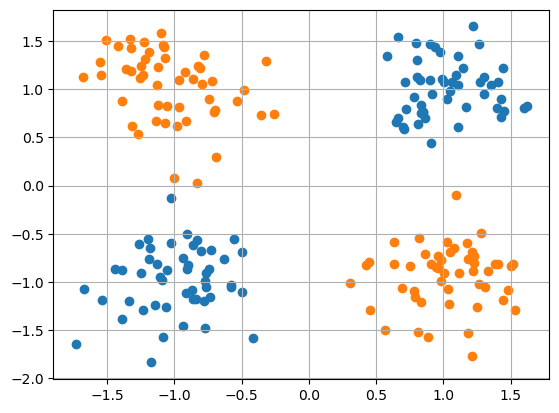

In [6]:
x_class_0 = x_train[y_train == 0]
x_class_1 = x_train[y_train == 1]

plt.scatter(x_class_0[:, 0], x_class_0[:, 1])
plt.scatter(x_class_1[:, 0], x_class_1[:, 1])

plt.grid()

#### Data Loader

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
class PseudoData(Dataset):
    
    def __init__(self, data_x, data_y=None):
        self.data_x = data_x.tolist()
        self.data_y = data_y
        if data_y is not None:
            self.data_y = data_y.tolist()
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        sample = {}
        sample['x'] = self.data_x[idx]
        if self.data_y is not None:
            sample['y'] = self.data_y[idx]
        return sample

In [9]:
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}
    
    for item in batch:
        for key in keys:
            data[key].append(item[key])
    return data

In [10]:
batch = [
    {'x':[1, 2], 'y':0},
    {'x':[3, 4], 'y':1}
]
batch_cvted = {'x':[[1, 2], [3, 4]], 'y':[0, 1]}

In [11]:
collate_fn(batch)

{'x': [[1, 2], [3, 4]], 'y': [0, 1]}

In [12]:
train_dataset = PseudoData(x_train, y_train)
valid_dataset = PseudoData(x_valid, y_valid)
test_dataset = PseudoData(x_test, y_test)

# train dataloader만 shuffle 수행
train_dataloader = DataLoader(
    train_dataset,
    batch_size=9,
    collate_fn=collate_fn,
    shuffle=True
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=False
)

In [13]:
for batch in train_dataloader:
    print(batch)
    break

{'x': [[-0.7761272945986104, 1.357495214451164], [-1.2445351657774615, 1.2370388185681882], [0.7208443223877589, 0.790610359344653], [-0.8019111204855629, -0.6758681709397283], [0.9830910434476962, -0.7749949206606284], [0.7904846746494089, -1.154248566964347], [0.5786696478479061, 1.3464723616403822], [-1.1866996710007198, 1.392284555542992], [0.9799635602194274, -0.9897186454792246]], 'y': [1, 1, 0, 0, 1, 1, 0, 1, 1]}


In [14]:
batch['x'], batch['y']

([[-0.7761272945986104, 1.357495214451164],
  [-1.2445351657774615, 1.2370388185681882],
  [0.7208443223877589, 0.790610359344653],
  [-0.8019111204855629, -0.6758681709397283],
  [0.9830910434476962, -0.7749949206606284],
  [0.7904846746494089, -1.154248566964347],
  [0.5786696478479061, 1.3464723616403822],
  [-1.1866996710007198, 1.392284555542992],
  [0.9799635602194274, -0.9897186454792246]],
 [1, 1, 0, 0, 1, 1, 0, 1, 1])

#### Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.init as init

In [16]:
class MLPClassification(nn.Module):
    
    def __init__(self, input_dim=2, hidden_size=32, output_dim=2):
        super().__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.linear_1(x))
        logit = self.linear(h)
        return logit

In [17]:
model = MLPClassification(input_dim=2, hidden_size=32, output_dim=2)